# Box Office Analysis For Microsoft Studios 
# Part 2


In [2]:
#Import neccessary libraries
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
from warnings import filterwarnings
filterwarnings('ignore')

### Certain directors bring in, on average, more revenue when compared to other directors. 

For our final hypothesis, we wanted to visualize the directors that have, on average, higher grossing films than other directors. Once we cleaned our data, subsetted the columns needed, and plotted our data, we would be able to tell which directors would fall into these parameters. After collecting this data, we would be able to recommend to Microsoft Studios a range of directors, who typically bring in the most revenue based on their films average grossing, that could direct any number of the studio's upcoming films. 


### Viewing Dataframes

Since we will be working on a different set of tables, we had to import the necessary CSVs, convert them to dataframes, and begin working on them. We decided that most of the tables from IMDB ('imdb.name.basics', 'imdb.title.akas', 'imdb.title.basics', 'imdb.title.crew', and 'imdb.title.ratings') would be viable. These tables would allow us to retrieve movie titles, director names, writer names, when the movie was released, runtime, average rating, and number of votes for each rating. We also pulled in The Numbers Movie Budgets (tn.movie_budgets) to acquire production budget, domestic grossing, and international grossing. With all these tools in hand, we would be able to acquire the average grossing by each director. 

In [3]:
#Read all CSV files as DataFrames
df_imdb_name_basics = pd.read_csv('zippedData/imdb.name.basics.csv.gz')
df_imdb_title = pd.read_csv('zippedData/imdb.title.akas.csv.gz')
df_imdb_basics = pd.read_csv('zippedData/imdb.title.basics.csv.gz')
df_imdb_title_crew = pd.read_csv('zippedData/imdb.title.crew.csv.gz')
df_imdb_title_principals = pd.read_csv('zippedData/imdb.title.principals.csv.gz')
df_imdb_title_ratings = pd.read_csv('zippedData/imdb.title.ratings.csv.gz')
df_dir_tn_movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')


In [4]:
#View the head of all dataframes to get a feel for the data.

# df_imdb_name_basics.head()
df_imdb_title.head()
# df_imdb_basics.head()
# df_imdb_title_crew.head()
# df_imdb_title_principals.head()
# df_imdb_title_ratings.head()
# df_dir_tn_movie_budgets.head()

,title_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,NaN,NaN,0.0
1,tt0369610,11,Jurashikku warudo,JP,NaN,imdbDisplay,NaN,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,NaN,imdbDisplay,NaN,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,NaN,NaN,short title,0.0
4,tt0369610,14,Jurassic World,FR,NaN,imdbDisplay,NaN,0.0


### Data Cleaning


In the IMDB_title dataframe, there are multiple entries with the same title_id. Further investigation showed that each title_id refered to a single movie and every entry for the same title_id was the same movie released in a different region. In order to make title_id unique, we decided to only look at the movies from the US region. We subsetted the dataframe to only include `title_id` & `title`.  We then checked for duplicates by `title_id` and dropped the duplicates if any were found

In [5]:
#Subset the movie titles so we only get movies in the US
df_imdb_title = df_imdb_title.query("region == 'US'")
#Subset columns to only what we need: title_id and title
df_imdb_title = df_imdb_title[['title_id','title']]
#Drop any duplicate 'title_id', just in case
df_imdb_title.title_id.duplicated().any().sum()
df_imdb_title.drop_duplicates(subset=['title_id'],inplace = True)
df_imdb_title

,title_id,title
12,tt0369610,Jurassic World 3D
50,tt0401729,John Carter of Mars
109,tt1014759,Alice in Wonderland: An IMAX 3D Experience
152,tt10379338,Guys Night Out
157,tt10446418,The Icon
...,...,...
331641,tt9310460,Coconut The Little Dragon Into The Jungle
331654,tt9358044,Hail Satan?
331673,tt9562694,Alien Warfare
331686,tt9705860,Dusan Vukotic Croatian Oscar Winner


In [6]:
df_imdb_name_basics

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer","tt1470654,tt0363631,tt0104030,tt0102898"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department","tt0114371,tt2004304,tt1618448,tt1224387"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator","tt0452644,tt0452692,tt3458030,tt2178256"
...,...,...,...,...,...,...
606643,nm9990381,Susan Grobes,NaN,NaN,actress,NaN
606644,nm9990690,Joo Yeon So,NaN,NaN,actress,"tt9090932,tt8737130"
606645,nm9991320,Madeline Smith,NaN,NaN,actress,"tt8734436,tt9615610"
606646,nm9991786,Michelle Modigliani,NaN,NaN,producer,NaN


Within the imdb.name.basics CSV, we first removed any persons that didn't work for any movie. We wouldn't be able to associate the person to any movie so removing them seemed logical. We also noticed that two columns, `birth_year` and `death_year`, were predominately NaN, as well as we weren't necessarily interested in those parameters, so we removed them. Finally we manipulated the column `known_for_titles` so that instead of a string of `title_id`, each `title_id` was an index of a list within the entry. 

In [7]:
#Get all individual names where they worked on a movie
df_imdb_name_basics = df_imdb_name_basics[df_imdb_name_basics['known_for_titles'].notna()]
#Select only necessary columns
df_imdb_name_basics = df_imdb_name_basics[['nconst','primary_name', 'primary_profession', 'known_for_titles']]
#Created a list within the column to seperate titles
df_imdb_name_basics['known_for_titles'] = df_imdb_name_basics['known_for_titles'].str.split(",")


In order to merge the dataframes imdb_title and imdb_basics, we viewed each dataframe and decided that we would be able to do an 'inner' merge on `title_id` and `tconst`. This would give us a combination of movies from the US region as well as their `start_year` and `runtime_minutes`. 

Before doing this, we were also just curious to see what the minimum movie release year was, 2010, and so we would also get a new table with the said attributes above as well as movies that are not older than 2010. We then subsetted the dataframe to only contain columns that are relevant to our data analysis.  

In [8]:
#Preview tables before merge
df_imdb_title
df_imdb_basics

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,NaN


In [9]:
#Oldest movies start in 2010 -- Curious to see the minimum movie year
df_imdb_basics.query("start_year == start_year.min()")

#Merge table on title_id and title_const 
df_imdb_title = df_imdb_title.merge(df_imdb_basics, how="inner", left_on="title_id", right_on="tconst")



In [10]:
#Preview table after merge
df_imdb_title.query("start_year == start_year.min()")
df_imdb_title

,title_id,title,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0369610,Jurassic World 3D,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi"
1,tt0401729,John Carter of Mars,tt0401729,John Carter,John Carter,2012,132.0,"Action,Adventure,Sci-Fi"
2,tt1014759,Alice in Wonderland: An IMAX 3D Experience,tt1014759,Alice in Wonderland,Alice in Wonderland,2010,108.0,"Adventure,Family,Fantasy"
3,tt10379338,Guys Night Out,tt10379338,Random Night Out,Random Night Out,2019,NaN,Comedy
4,tt10446418,The Icon,tt10446418,Icon,Icon,2011,215.0,"Documentary,History"
...,...,...,...,...,...,...,...,...
47428,tt9310460,Coconut The Little Dragon Into The Jungle,tt9310460,Coconut the Little Dragon 2 Into the Jungle,Der kleine Drache Kokosnuss - Auf in den Dschu...,2018,NaN,"Adventure,Animation,Comedy"
47429,tt9358044,Hail Satan?,tt9358044,Hail Satan?,Hail Satan?,2019,95.0,Documentary
47430,tt9562694,Alien Warfare,tt9562694,Alien Warfare,Alien Warfare,2019,88.0,"Action,Sci-Fi"
47431,tt9705860,Dusan Vukotic Croatian Oscar Winner,tt9705860,Dusan Vukotic Croatian Oscar Winner,Dusan Vukotic hrvatski okarovac,2011,55.0,Documentary


In [16]:
#Get column names to subset table
df_imdb_title.columns
#Subset tables to columns we want
df_imdb_title = df_imdb_title[['title_id', 'title', 'start_year', 'runtime_minutes']]

In [17]:
#Preview table after subsetting
df_imdb_title

,title_id,title,start_year,runtime_minutes
0,tt0369610,Jurassic World 3D,2015,124.0
1,tt0401729,John Carter of Mars,2012,132.0
2,tt1014759,Alice in Wonderland: An IMAX 3D Experience,2010,108.0
3,tt10379338,Guys Night Out,2019,NaN
4,tt10446418,The Icon,2011,215.0
...,...,...,...,...
47428,tt9310460,Coconut The Little Dragon Into The Jungle,2018,NaN
47429,tt9358044,Hail Satan?,2019,95.0
47430,tt9562694,Alien Warfare,2019,88.0
47431,tt9705860,Dusan Vukotic Croatian Oscar Winner,2011,55.0


With this table cleaned, we were able to merge it with imdb_title_crew dataframe (see below), using `title_id` & `tconst` respectively. This allowed for us to get the `directors` and `writers`, from imdb_title_crew dataframe, associated with the movie information in the imdb_title dataframe. 

In [12]:
df_imdb_title_crew.info()
df_imdb_title_crew.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   tconst     146144 non-null  object
 1   directors  140417 non-null  object
 2   writers    110261 non-null  object
dtypes: object(3)
memory usage: 3.3+ MB


,tconst,directors,writers
0,tt0285252,nm0899854,nm0899854
1,tt0438973,NaN,"nm0175726,nm1802864"
2,tt0462036,nm1940585,nm1940585
3,tt0835418,nm0151540,"nm0310087,nm0841532"
4,tt0878654,"nm0089502,nm2291498,nm2292011",nm0284943


In [13]:
#Merge table to get directors for each movie using key title_id and tconst
title_crew_df= df_imdb_title.merge(df_imdb_title_crew, how="inner", left_on="title_id", right_on="tconst")
title_crew_df

,title_id,title,start_year,runtime_minutes,tconst,directors,writers
0,tt0369610,Jurassic World 3D,2015,124.0,tt0369610,nm1119880,"nm0415425,nm0798646,nm1119880,nm2081046,nm0000341"
1,tt0401729,John Carter of Mars,2012,132.0,tt0401729,nm0004056,"nm0004056,nm0028764,nm0149290,nm0123194"
2,tt1014759,Alice in Wonderland: An IMAX 3D Experience,2010,108.0,tt1014759,nm0000318,"nm0941314,nm0140902"
3,tt10379338,Guys Night Out,2019,NaN,tt10379338,nm2584377,nm10715703
4,tt10446418,The Icon,2011,215.0,tt10446418,nm4270970,NaN
...,...,...,...,...,...,...,...
47428,tt9310460,Coconut The Little Dragon Into The Jungle,2018,NaN,tt9310460,nm2106115,"nm2173401,nm0910419"
47429,tt9358044,Hail Satan?,2019,95.0,tt9358044,nm3704075,NaN
47430,tt9562694,Alien Warfare,2019,88.0,tt9562694,nm1371053,"nm6188062,nm10597982,nm5703427"
47431,tt9705860,Dusan Vukotic Croatian Oscar Winner,2011,55.0,tt9705860,nm1248890,"nm1082058,nm1248890"


Initially, we wanted to acquire some analysis on `runtime_minutes`, `averagerating`, and `numvotes` but due to time constraints, we weren't able to. But below we merged our table above with its rating and dropped the columns we deemed weren't necessary or that were redundant. 

In [14]:
df_imdb_title_ratings

#Merged tables to get rating 
#if we want to analyze that on keys "title_id" and "tconst"
movie_title_crew_rating_df = title_crew_df.merge(df_imdb_title_ratings, how="inner", left_on="title_id", right_on="tconst")
movie_title_crew_rating_df


,title_id,title,start_year,runtime_minutes,tconst_x,directors,writers,tconst_y,averagerating,numvotes
0,tt0369610,Jurassic World 3D,2015,124.0,tt0369610,nm1119880,"nm0415425,nm0798646,nm1119880,nm2081046,nm0000341",tt0369610,7.0,539338
1,tt0401729,John Carter of Mars,2012,132.0,tt0401729,nm0004056,"nm0004056,nm0028764,nm0149290,nm0123194",tt0401729,6.6,241792
2,tt1014759,Alice in Wonderland: An IMAX 3D Experience,2010,108.0,tt1014759,nm0000318,"nm0941314,nm0140902",tt1014759,6.5,358813
3,tt1182315,Dark Buenos Aires,2010,90.0,tt1182315,nm1413776,"nm0267066,nm1413776",tt1182315,3.4,123
4,tt1194173,Marcher,2012,135.0,tt1194173,nm0006904,"nm0006904,nm0319659,nm0524924",tt1194173,6.7,268678
...,...,...,...,...,...,...,...,...,...,...
26649,tt7315648,OJ: Guilty in Vegas,2017,100.0,tt7315648,NaN,NaN,tt7315648,6.0,27
26650,tt9080630,Girl/Girl Scene,2019,122.0,tt9080630,nm2717314,nm2717314,tt9080630,2.1,112
26651,tt9310460,Coconut The Little Dragon Into The Jungle,2018,NaN,tt9310460,nm2106115,"nm2173401,nm0910419",tt9310460,5.9,43
26652,tt9358044,Hail Satan?,2019,95.0,tt9358044,nm3704075,NaN,tt9358044,6.8,628


In [15]:
#Subset table to get only columns we wanted and drop NAs in title and director
# so we have viable data.
movie_title_crew_rating_df = movie_title_crew_rating_df.loc[:,['title_id','title', 'directors', 'writers','averagerating','numvotes','start_year','runtime_minutes']]

movie_title_crew_rating_df.dropna(subset=['title','directors','writers'], inplace=True)
movie_title_crew_rating_df

,title_id,title,directors,writers,averagerating,numvotes,start_year,runtime_minutes
0,tt0369610,Jurassic World 3D,nm1119880,"nm0415425,nm0798646,nm1119880,nm2081046,nm0000341",7.0,539338,2015,124.0
1,tt0401729,John Carter of Mars,nm0004056,"nm0004056,nm0028764,nm0149290,nm0123194",6.6,241792,2012,132.0
2,tt1014759,Alice in Wonderland: An IMAX 3D Experience,nm0000318,"nm0941314,nm0140902",6.5,358813,2010,108.0
3,tt1182315,Dark Buenos Aires,nm1413776,"nm0267066,nm1413776",3.4,123,2010,90.0
4,tt1194173,Marcher,nm0006904,"nm0006904,nm0319659,nm0524924",6.7,268678,2012,135.0
...,...,...,...,...,...,...,...,...
26647,tt7298028,Death of Love,nm3583561,nm3583561,9.1,28,2017,NaN
26648,tt7315526,Devil's Tree: Rooted Evil,"nm2845202,nm2608588","nm2608588,nm2845202",4.9,1466,2018,76.0
26650,tt9080630,Girl/Girl Scene,nm2717314,nm2717314,2.1,112,2019,122.0
26651,tt9310460,Coconut The Little Dragon Into The Jungle,nm2106115,"nm2173401,nm0910419",5.9,43,2018,NaN


Like earlier with `known_for_titles` in the imdb_name_basics dataframe, we had to manipulate the directors and writers columns, so instead of a string it would be a list, since multiple directors and multiple writers can work on one movie.

In [16]:
#Split the director string into a list
movie_title_crew_rating_df['writers'] = movie_title_crew_rating_df.loc[:,'writers'].str.split(",")
movie_title_crew_rating_df['directors'] = movie_title_crew_rating_df.loc[:,'directors'].str.split(",")

In [18]:
#Double checking the string became list
print(type(movie_title_crew_rating_df['writers'].iloc[0]))
print(type(movie_title_crew_rating_df['directors'].iloc[0]))
movie_title_crew_rating_df.isna().sum()

<class 'list'>
<class 'list'>


title_id              0
title                 0
directors             0
writers               0
averagerating         0
numvotes              0
start_year            0
runtime_minutes    1645
dtype: int64

In [19]:
#Dropping all na's and resetting the index
#Weren't any nas or duplicates, but just for reassurement
movie_title_crew_rating_df.dropna(inplace=True)
movie_title_crew_rating_df.reset_index(inplace = True)

In [20]:
#Previewing table after everything
movie_title_crew_rating_df

,index,title_id,title,directors,writers,averagerating,numvotes,start_year,runtime_minutes
0,0,tt0369610,Jurassic World 3D,[nm1119880],"[nm0415425, nm0798646, nm1119880, nm2081046, n...",7.0,539338,2015,124.0
1,1,tt0401729,John Carter of Mars,[nm0004056],"[nm0004056, nm0028764, nm0149290, nm0123194]",6.6,241792,2012,132.0
2,2,tt1014759,Alice in Wonderland: An IMAX 3D Experience,[nm0000318],"[nm0941314, nm0140902]",6.5,358813,2010,108.0
3,3,tt1182315,Dark Buenos Aires,[nm1413776],"[nm0267066, nm1413776]",3.4,123,2010,90.0
4,4,tt1194173,Marcher,[nm0006904],"[nm0006904, nm0319659, nm0524924]",6.7,268678,2012,135.0
...,...,...,...,...,...,...,...,...,...
21506,26645,tt7275980,Mushino,[nm9215844],"[nm9215844, nm9215845]",5.1,28,2017,80.0
21507,26646,tt7293920,The Fare,[nm2952421],[nm6446224],6.8,20,2018,82.0
21508,26648,tt7315526,Devil's Tree: Rooted Evil,"[nm2845202, nm2608588]","[nm2608588, nm2845202]",4.9,1466,2018,76.0
21509,26650,tt9080630,Girl/Girl Scene,[nm2717314],[nm2717314],2.1,112,2019,122.0


For our final steps in the data cleaning process, we had to first clean the df_dir_tn_movie_budgets table as well as merge it with the main table we have been working with. 

We first had to clean the `production_budget`, `domestic_gross`, and `worldwide_gross` columns to remove punctuations and symbols, as well as convert it to a number that is more easily readable. We then also converted it from string to floats and we were on our way.

We also had to parse through `release_date` to retrieve the `year` in its own seperate column. Once that was all done, we were ready to merge the tables.

Since there wasn't an obvious key that works for both table, we had to create unique combination of columns to match the tables appropriately. We found the combination of `title` and `year` would be appropriate and used that to merge the two tables. 

In [21]:
#Previewing table to merge with above table. 
#Decided that movie title+year would be the best key since title_id isn't there
df_dir_tn_movie_budgets

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


In [22]:
#Quickly cleaning each column, removing punctuations and symbols
df_dir_tn_movie_budgets['production_budget_edited'] = df_dir_tn_movie_budgets.production_budget.str.replace('$', '')
df_dir_tn_movie_budgets['production_budget_edited'] = df_dir_tn_movie_budgets['production_budget_edited'].str.replace(',', '')
df_dir_tn_movie_budgets['production_budget_edited'] = df_dir_tn_movie_budgets['production_budget_edited'].astype(float)

df_dir_tn_movie_budgets['domestic_gross_edited'] = df_dir_tn_movie_budgets.domestic_gross.str.replace('$', '')
df_dir_tn_movie_budgets['domestic_gross_edited'] = df_dir_tn_movie_budgets['domestic_gross_edited'].str.replace(',', '')
df_dir_tn_movie_budgets['domestic_gross_edited'] = df_dir_tn_movie_budgets['domestic_gross_edited'].astype(float)

df_dir_tn_movie_budgets['worldwide_gross_edited'] = df_dir_tn_movie_budgets.worldwide_gross.str.replace('$', '')
df_dir_tn_movie_budgets['worldwide_gross_edited'] = df_dir_tn_movie_budgets['worldwide_gross_edited'].str.replace(',', '')
df_dir_tn_movie_budgets['worldwide_gross_edited'] = df_dir_tn_movie_budgets['worldwide_gross_edited'].astype(float)

df_dir_tn_movie_budgets['production_budget_edited'] = round((df_dir_tn_movie_budgets['production_budget_edited'] / 1000000),1)
df_dir_tn_movie_budgets['domestic_gross_edited'] = round((df_dir_tn_movie_budgets['domestic_gross_edited'] / 1000000),1)
df_dir_tn_movie_budgets['worldwide_gross_edited'] = round((df_dir_tn_movie_budgets['worldwide_gross_edited'] / 1000000),1)

#Split the date to also a year column to use as key
df_dir_tn_movie_budgets['release_date'] = pd.to_datetime(df_dir_tn_movie_budgets['release_date'])
df_dir_tn_movie_budgets['year'] = pd.DatetimeIndex(df_dir_tn_movie_budgets['release_date']).year

In [23]:
#Selected only the columns necessary
df_dir_tn_movie_budgets = df_dir_tn_movie_budgets.loc[:,['movie', 'production_budget_edited', 'domestic_gross_edited','worldwide_gross_edited','year']]

In [24]:
#Previewing it after all edits
df_dir_tn_movie_budgets

,movie,production_budget_edited,domestic_gross_edited,worldwide_gross_edited,year
0,Avatar,425.0,760.5,2776.3,2009
1,Pirates of the Caribbean: On Stranger Tides,410.6,241.1,1045.7,2011
2,Dark Phoenix,350.0,42.8,149.8,2019
3,Avengers: Age of Ultron,330.6,459.0,1403.0,2015
4,Star Wars Ep. VIII: The Last Jedi,317.0,620.2,1316.7,2017
...,...,...,...,...,...
5777,Red 11,0.0,0.0,0.0,2018
5778,Following,0.0,0.0,0.2,1999
5779,Return to the Land of Wonders,0.0,0.0,0.0,2005
5780,A Plague So Pleasant,0.0,0.0,0.0,2015


In [25]:
#Previewing main DataFrame
movie_title_crew_rating_df

,index,title_id,title,directors,writers,averagerating,numvotes,start_year,runtime_minutes
0,0,tt0369610,Jurassic World 3D,[nm1119880],"[nm0415425, nm0798646, nm1119880, nm2081046, n...",7.0,539338,2015,124.0
1,1,tt0401729,John Carter of Mars,[nm0004056],"[nm0004056, nm0028764, nm0149290, nm0123194]",6.6,241792,2012,132.0
2,2,tt1014759,Alice in Wonderland: An IMAX 3D Experience,[nm0000318],"[nm0941314, nm0140902]",6.5,358813,2010,108.0
3,3,tt1182315,Dark Buenos Aires,[nm1413776],"[nm0267066, nm1413776]",3.4,123,2010,90.0
4,4,tt1194173,Marcher,[nm0006904],"[nm0006904, nm0319659, nm0524924]",6.7,268678,2012,135.0
...,...,...,...,...,...,...,...,...,...
21506,26645,tt7275980,Mushino,[nm9215844],"[nm9215844, nm9215845]",5.1,28,2017,80.0
21507,26646,tt7293920,The Fare,[nm2952421],[nm6446224],6.8,20,2018,82.0
21508,26648,tt7315526,Devil's Tree: Rooted Evil,"[nm2845202, nm2608588]","[nm2608588, nm2845202]",4.9,1466,2018,76.0
21509,26650,tt9080630,Girl/Girl Scene,[nm2717314],[nm2717314],2.1,112,2019,122.0


In [26]:
#Merge two tables on year and title, dropped na, and dropped index
movie_title_crew_rating_df = movie_title_crew_rating_df.merge(df_dir_tn_movie_budgets, left_on=['title','start_year'], right_on=['movie','year'])
movie_title_crew_rating_df = movie_title_crew_rating_df.dropna()
movie_title_crew_rating_df = movie_title_crew_rating_df.drop(['index'], axis=1)

In [27]:
#Subset table for the columns needed and previewed
movie_title_crew_rating_df = movie_title_crew_rating_df.loc[:,['title_id','title','directors','writers',
                                                               'averagerating','numvotes','runtime_minutes',
                                                              'production_budget_edited','domestic_gross_edited',
                                                              'worldwide_gross_edited','year']]
movie_title_crew_rating_df

,title_id,title,directors,writers,averagerating,numvotes,runtime_minutes,production_budget_edited,domestic_gross_edited,worldwide_gross_edited,year
0,tt1235522,Broken City,[nm0400441],[nm3017566],6.2,71704,109.0,35.0,19.7,34.5,2013
1,tt1343092,The Great Gatsby,[nm0525303],"[nm0525303, nm0668902, nm0280234]",7.3,433165,143.0,190.0,144.8,351.0,2013
2,tt1343727,Dredd,[nm0871428],"[nm0905957, nm0264338, nm0307497]",7.1,234616,95.0,45.0,13.4,41.5,2012
3,tt1401152,Unknown,[nm1429471],"[nm0124700, nm0180508, nm0885857]",6.9,235167,113.0,40.0,63.7,136.1,2011
4,tt1604171,Prom,[nm0638271],[nm2251854],5.4,14279,104.0,8.0,10.1,10.8,2011
...,...,...,...,...,...,...,...,...,...,...,...
970,tt3348730,Jigsaw,"[nm1294962, nm1294961]","[nm0831457, nm1539257]",5.8,57184,92.0,10.0,38.1,102.4,2017
971,tt4651520,Bad Moms,"[nm0601859, nm0524190]","[nm0524190, nm0601859]",6.2,100952,100.0,20.0,113.3,181.0,2016
972,tt5442430,Life,[nm1174251],"[nm1014201, nm1116660]",6.6,182840,104.0,58.0,30.2,100.9,2017
973,tt5462602,The Big Sick,[nm0795290],"[nm5077137, nm3529685]",7.6,104008,120.0,5.0,42.9,54.0,2017


>Lo and behold, our cleaned dataframe (see above) with the necessary columns ready to be used for analysis

### Data Analysis

Finally with our table ready for use, we were able to analyze the data. First, we sorted the values by `worldwide_gross_edited` just to get an idea of which directors would be at the top. 

In [28]:
movie_title_crew_rating_df.sort_values('worldwide_gross_edited', ascending=False)


,title_id,title,directors,writers,averagerating,numvotes,runtime_minutes,production_budget_edited,domestic_gross_edited,worldwide_gross_edited,year
945,tt4154756,Avengers: Infinity War,"[nm0751577, nm0751648]","[nm1321655, nm1321656, nm0498278, nm0456158, n...",8.5,670926,149.0,300.0,678.8,2048.1,2018
618,tt2820852,Furious 7,[nm1490123],"[nm0604555, nm0860155]",7.2,335074,137.0,190.0,353.0,1518.7,2015
303,tt1825683,Black Panther,[nm3363032],"[nm3363032, nm1963288, nm0498278, nm0456158]",7.3,516148,134.0,200.0,700.1,1348.3,2018
753,tt4881806,Jurassic World: Fallen Kingdom,[nm1291105],"[nm2081046, nm1119880, nm0000341]",6.2,219125,128.0,170.0,417.7,1305.8,2018
114,tt2294629,Frozen,"[nm0118333, nm1601644]","[nm1601644, nm0026153, nm0118333, nm2280850]",7.5,516998,102.0,150.0,400.7,1272.5,2013
...,...,...,...,...,...,...,...,...,...,...,...
462,tt1716760,Raymond Did It,[nm3728366],[nm3728366],3.3,211,83.0,0.0,0.0,0.0,2011
460,tt1653002,Dysfunctional Friends,[nm2092442],[nm2092442],5.2,760,111.0,1.8,0.0,0.0,2012
548,tt1134666,Dwegons and Leprechauns,[nm0909895],"[nm10065918, nm10065917, nm0587044, nm0909895]",4.2,84,98.0,20.0,0.0,0.0,2014
840,tt3359872,Doc Holliday's Revenge,[nm0213983],[nm0437490],3.8,104,84.0,1.0,0.0,0.0,2014


Initially, we sorted the dataframe both by `worldwide_gross_edited` and `domestic_gross_edited` with no constraints. 
>To get the directors actual name, we took the directors key from the `directors` column and mapped it to the imdb_name_basics dataframe to actually retrieve the name. 

Once tabulated and plotted, we realized it didn't make sense to compare a group of directors to just a single director. We weren't certain that groups of directors have worked on multiple movies together and the likelihood of it is very low. This would cause a skew in the data, for example, the Russo Brothers, who worked on Avengers: Infinity War, had one of the highest grossing films of all time. So their average could very well be just be that one film, whereas we wanted one director with multiple films under their belt to show consistency with their film's grossing.

We decided to analyze movies that only have one director and compare single directors to one another. 

###### Movies including more than one director:

In [29]:
#Go by all movies including ones with more than one director

#Sort by international gross
res = pd.DataFrame(movie_title_crew_rating_df.groupby(movie_title_crew_rating_df['directors'].map(tuple))[['worldwide_gross_edited','domestic_gross_edited']].mean())
res_sorted_WWGE = res.sort_values('worldwide_gross_edited', ascending=False)

#Retrieve the actual names of the top 10 grossing directors
top_10_wwge = res_sorted_WWGE[:10]
directors_name_list = []
for x, index in enumerate(top_10_wwge.index):
    temp_list = []
    for y in range(len(top_10_wwge.index[x])):
        temp_list.append(df_imdb_name_basics.query("nconst == '{}'".format(top_10_wwge.index[x][y])).iloc[0]['primary_name'])
    directors_name_list.append(temp_list)
#Append into the dataframe 
top_10_wwge['directors_name'] = directors_name_list


In [30]:
top_10_wwge = top_10_wwge.round(2)
top_10_wwge = top_10_wwge.set_index('directors_name')
top_10_wwge

,worldwide_gross_edited,domestic_gross_edited
directors_name,,
"[Anthony Russo, Joe Russo]",2048.10,678.80
[James Wan],1518.70,353.00
"[Chris Buck, Jennifer Lee]",1272.50,400.70
"[Pierre Coffin, Kyle Balda]",1160.30,336.00
[Sam Mendes],1110.50,304.40
"[Kyle Balda, Eric Guillon, Pierre Coffin]",1034.70,264.60
"[Jared Bush, Byron Howard, Rich Moore]",1019.40,341.30
[Peter Jackson],974.33,272.17
[Jon Favreau],962.90,364.00


In [31]:
#Sort by domestic gross
res_sorted_DGE = res.sort_values('domestic_gross_edited', ascending=False)
top_10_dge = res_sorted_DGE[:10]
directors_name_list = []
#Retrieve directors name
for x, index in enumerate(top_10_dge.index):
    temp_list = []
    for y in range(len(top_10_dge.index[x])):
        temp_list.append(df_imdb_name_basics.query("nconst == '{}'".format(top_10_dge.index[x][y])).iloc[0]['primary_name'])
    directors_name_list.append(temp_list)

#Append into the dataframe
top_10_dge['directors_name'] = tuple(directors_name_list)
top_10_dge = top_10_dge.round(2)
top_10_dge = top_10_dge.set_index('directors_name')
top_10_dge

,worldwide_gross_edited,domestic_gross_edited
directors_name,,
"[Anthony Russo, Joe Russo]",2048.10,678.80
[Patty Jenkins],821.10,412.60
"[Chris Buck, Jennifer Lee]",1272.50,400.70
[Gareth Edwards],789.10,366.45
[Jon Favreau],962.90,364.00
[Tim Miller],801.00,363.10
"[Pete Docter, Ronnie Del Carmen]",854.20,356.50
[James Wan],1518.70,353.00
[Brad Bird],724.55,351.00


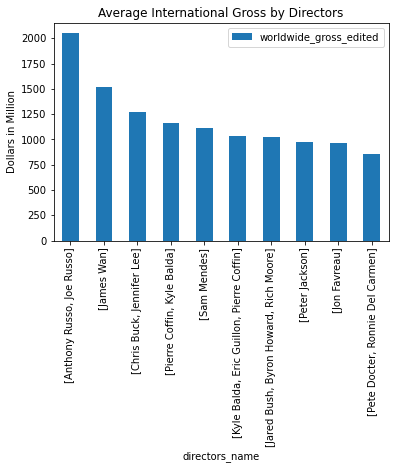

In [39]:
top_10_wwge.plot(y='worldwide_gross_edited',kind = 'bar',
                 title = "Average International Gross by Directors",
                 ylabel = "Dollars in Million");


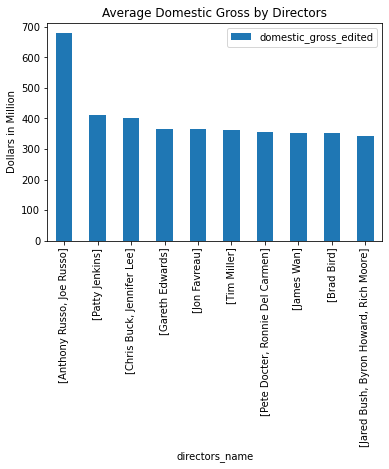

In [40]:
top_10_dge.plot(y='domestic_gross_edited',kind = 'bar',
               title = "Average Domestic Gross by Directors",
               ylabel = "Dollars in Million");

###### Movies with a single director:

In [34]:
#Get Movies with One Director and check the mean for their movie gross
movie_one_director_df = movie_title_crew_rating_df.query("directors.str.len() == 1 ").sort_values('worldwide_gross_edited', ascending=False)


In [35]:
#Get Movies with One Director and check the mean for their movie gross
movie_one_director_df = movie_title_crew_rating_df.query("directors.str.len() == 1 ").sort_values('worldwide_gross_edited', ascending=False)
res = pd.DataFrame(movie_one_director_df.groupby(movie_title_crew_rating_df['directors'].map(tuple))[['worldwide_gross_edited','domestic_gross_edited']].mean())
res_sorted_WWGE_one_dir = res.sort_values('worldwide_gross_edited', ascending=False)

top_10_wwge_one_dir = res_sorted_WWGE_one_dir[:10]
directors_name_list = []
for x, index in enumerate(top_10_wwge_one_dir.index):
    for y in range(len(top_10_wwge_one_dir.index[x])):
        directors_name_list.append(df_imdb_name_basics.query("nconst == '{}'".format(top_10_wwge_one_dir.index[x][y])).iloc[0]['primary_name'])

top_10_wwge_one_dir['directors_name'] = directors_name_list
top_10_wwge_one_dir = top_10_wwge_one_dir.round(2)
# top_10_wwge_one_dir = top_10_wwge_one_dir.set_index('directors_name')
top_10_wwge_one_dir

,worldwide_gross_edited,domestic_gross_edited,directors_name
directors,,,
"(nm1490123,)",1518.70,353.00,James Wan
"(nm0005222,)",1110.50,304.40,Sam Mendes
"(nm0001392,)",974.33,272.17,Peter Jackson
"(nm0269463,)",962.90,364.00,Jon Favreau
"(nm0169806,)",847.00,315.10,Taika Waititi
"(nm0420941,)",821.10,412.60,Patty Jenkins
"(nm1783265,)",801.00,363.10,Tim Miller
"(nm2284484,)",789.10,366.45,Gareth Edwards
"(nm0834902,)",758.50,241.40,Robert Stromberg


In [36]:
res_sorted_DGE = res.sort_values('domestic_gross_edited', ascending=False)
top_10_dge_one_dir = res_sorted_DGE[:10]
directors_name_list = []
for x, index in enumerate(top_10_dge_one_dir.index):
    for y in range(len(top_10_dge_one_dir.index[x])):
        directors_name_list.append(df_imdb_name_basics.query("nconst == '{}'".format(top_10_dge_one_dir.index[x][y])).iloc[0]['primary_name'])

top_10_dge_one_dir['directors_name'] = (directors_name_list)
top_10_dge_one_dir = top_10_dge_one_dir.round(2)
# top_10_dge_one_dir = top_10_dge_one_dir.set_index('directors_name')
top_10_dge_one_dir

,worldwide_gross_edited,domestic_gross_edited,directors_name
directors,,,
"(nm0420941,)",821.10,412.60,Patty Jenkins
"(nm2284484,)",789.10,366.45,Gareth Edwards
"(nm0269463,)",962.90,364.00,Jon Favreau
"(nm1783265,)",801.00,363.10,Tim Miller
"(nm1490123,)",1518.70,353.00,James Wan
"(nm0083348,)",724.55,351.00,Brad Bird
"(nm0169806,)",847.00,315.10,Taika Waititi
"(nm0005222,)",1110.50,304.40,Sam Mendes
"(nm3363032,)",513.13,275.33,Ryan Coogler


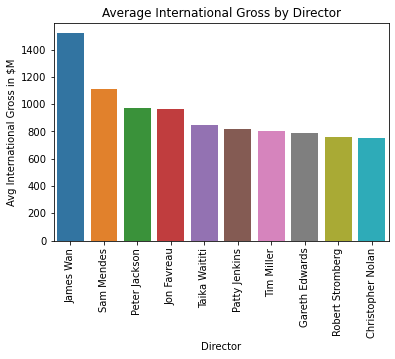

In [41]:
wwChart = sns.barplot(x='directors_name', y='worldwide_gross_edited', data = top_10_wwge_one_dir)
wwChart.set_xticklabels(wwChart.get_xticklabels(), rotation=90)
wwChart.set(title = "Average International Gross by Director",
            xlabel = "Director",
            ylabel = "Avg International Gross in $M");


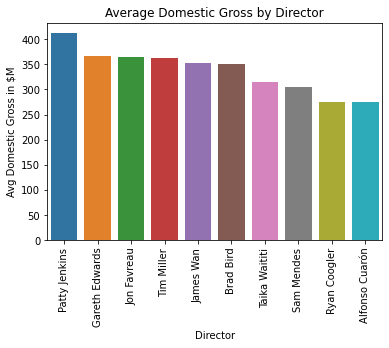

In [42]:
dgChart = sns.barplot(x='directors_name', y='domestic_gross_edited', data = top_10_dge_one_dir)
dgChart.set_xticklabels(dgChart.get_xticklabels(), rotation=90)
dgChart.set(title = "Average Domestic Gross by Director",
            xlabel = "Director",
            ylabel = "Avg Domestic Gross in $M");

## Conclusion

We can conclude that there is a range of directors that have a higher average domestic gross and a higher average international gross. If Microsoft Studios is in search for a director for a new film, the studio should choose from this list, dependent on audience (domestic vs international), and can increase the likelihood that the film will have a strong box office performance.

Also, Microsoft Studios should highly consider the specialities of these directors. We wouldn't recommend choosing James Wan, known for his horror movies, to direct a family film or Sam Mendes, known for movies such as American Beauty and 1917, to direct an animation film.